# Secure Data Disclosure: Client Side Smartnoise-Synth

This notebook showcases how researcher could use the Secure Data Disclosure system. It explains the different functionnalities provided by the `lomas-client` client library to interact with the secure server.

The secure data are never visible by researchers. They can only access to differentially private responses via queries to the server.

Each user has access to one or multiple projects and for each dataset has a limited budget with $\epsilon$ and $\delta$ values.

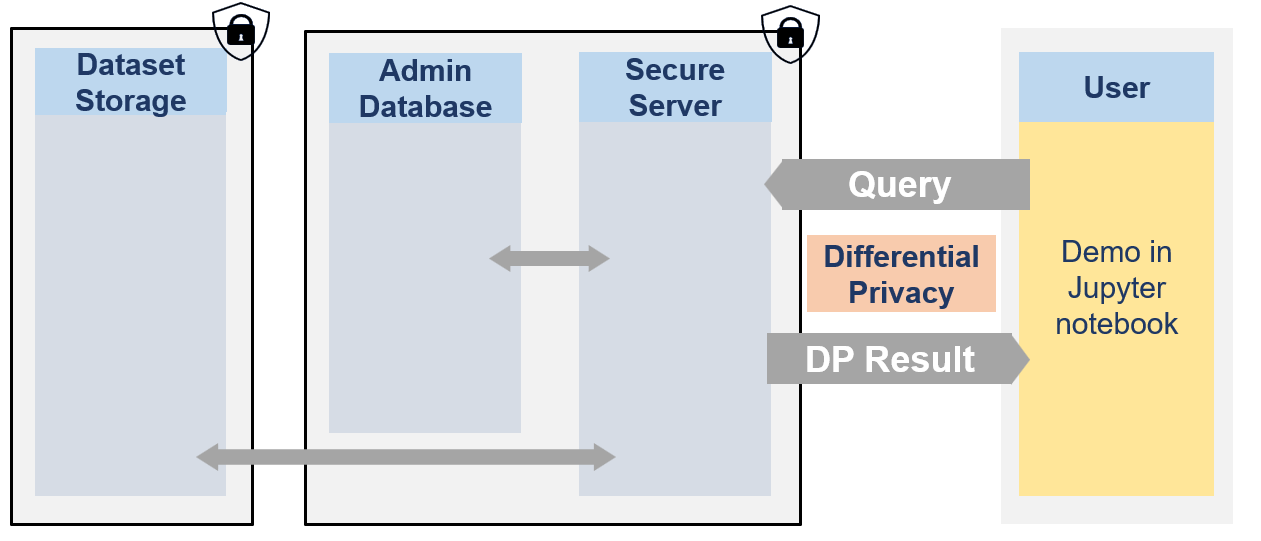

In [1]:
from IPython.display import Image
Image(filename="images/image_demo_client.png", width=800)

🐧🐧🐧
In this notebook the researcher is a penguin researcher named Dr. Antarctica. She aims to do a grounbdbreaking research on various penguins dimensions.

Therefore, the powerful queen Icerbegina 👑 had the data collected. But in order to get the penguins to agree to participate she promised them that no one would be able to look at the data and that no one would be able to guess the bill width of any specific penguin (which is very sensitive information) from the data. Nobody! Not even the researchers. The queen hence stored the data on the Secure Data Disclosure Server and only gave a small budget to Dr. Antarctica.

This is not a problem for Dr. Antarctica as she does not need to see the data to make statistics thanks to the Secure Data Disclosure Client library `fso-sdd-demo`. 
🐧🐧🐧

## Step 1: Install the library
To interact with the secure server on which the data is stored, Dr.Antartica first needs to install the library `fso-sdd-demo` on her local developping environment. 

It can be installed via the pip command:

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
# !pip install lomas_client

In [3]:
from lomas_client import Client
import numpy as np

## Step 2: Initialise the client

Once the library is installed, a Client object must be created. It is responsible for sending sending requests to the server and processing responses in the local environment. It enables a seamless interaction with the server. 

To create the client, Dr. Antartica needs to give it a few parameters:
- a url: the root application endpoint to the remote secure server.
- user_name: her name as registered in the database (Dr. Alice Antartica)
- dataset_name: the name of the dataset that she wants to query (PENGUIN)

She will only be able to query on the real dataset if the queen Icergina has previously made her an account in the database, given her access to the PENGUIN dataset and has given her some epsilon and delta credit (as is done in the Admin Notebook for Users and Datasets management).

In [4]:
APP_URL = "http://lomas_server"
USER_NAME = "Dr. Antartica"
DATASET_NAME = "PENGUIN"
client = Client(url=APP_URL, user_name = USER_NAME, dataset_name = DATASET_NAME)

And that's it for the preparation. She is now ready to use the various functionnalities offered by `lomas-client`.

## Step 3: Metadata and dummy dataset

### Getting dataset metadata

Dr. Antartica has never seen the data and as a first step to understand what is available to her, she would like to check the metadata of the dataset. Therefore, she just needs to call the `get_dataset_metadata()` function of the client. As this is public information, this does not cost any budget.

This function returns metadata information in a format based on [SmartnoiseSQL dictionary format](https://docs.smartnoise.org/sql/metadata.html#dictionary-format), where among other, there is information about all the available columns, their type, bound values (see Smartnoise page for more details). Any metadata is required for Smartnoise-SQL is also required here and additional information such that the different categories in a string type column column can be added.

In [5]:
penguin_metadata = client.get_dataset_metadata()
penguin_metadata

{'max_ids': 1,
 'row_privacy': True,
 'censor_dims': False,
 'columns': {'species': {'type': 'string',
   'cardinality': 3,
   'categories': ['Adelie', 'Chinstrap', 'Gentoo']},
  'island': {'type': 'string',
   'cardinality': 3,
   'categories': ['Torgersen', 'Biscoe', 'Dream']},
  'bill_length_mm': {'type': 'float', 'lower': 30.0, 'upper': 65.0},
  'bill_depth_mm': {'type': 'float', 'lower': 13.0, 'upper': 23.0},
  'flipper_length_mm': {'type': 'float', 'lower': 150.0, 'upper': 250.0},
  'body_mass_g': {'type': 'float', 'lower': 2000.0, 'upper': 7000.0},
  'sex': {'type': 'string',
   'cardinality': 2,
   'categories': ['MALE', 'FEMALE']}},
 'rows': 344}

Based on this Dr. Antartica knows that there are 7 columns, 3 of string type (species, island, sex) with their associated categories (i.e. the species column has 3 possibilities: 'Adelie', 'Chinstrap', 'Gentoo') and 4 of float type (bill length, bill depth, flipper length and body mass) with their associated bounds (i.e. the body mass of penguin ranges from 2000 to 7000 gramms). She also knows based on the field `max_ids: 1` that each penguin can only be once in the dataset and on the field `row_privacy: True` that each row represents a single penguin. 

### Get a dummy dataset

Now, that she has seen and understood the metadata, she wants to get an even better understanding of the dataset (but is still not able to see it). A solution to have an idea of what the dataset looks like it to create a dummy dataset. 

Based on the public metadata of the dataset, a random dataframe can be created created. By default, there will be 100 rows and the seed is set to 42 to ensure reproducibility, but these 2 variables can be changed to obtain different dummy datasets.
Getting a dummy dataset does not affect the budget as there is no differential privacy here. It is not a synthetic dataset and all that could be learn here is already present in the public metadata (it is created randomly on the fly based on the metadata).

Dr. Antartica first create a dummy dataset with 200 rows and chooses a seed of 0.

In [6]:
NB_ROWS = 200
SEED = 0

In [7]:
df_dummy = client.get_dummy_dataset(
    nb_rows = NB_ROWS, 
    seed = SEED
)

print(df_dummy.shape)
df_dummy.head()

(200, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo,Biscoe,49.208473,16.117959,190.125950,2873.291927,FEMALE
1,Gentoo,Torgersen,55.031628,19.963435,242.929142,3639.940005,FEMALE
2,Chinstrap,Torgersen,51.096718,16.777518,159.961493,5401.743330,MALE
3,Adelie,Biscoe,49.070911,14.796037,244.530153,2316.038092,MALE
4,Chinstrap,Biscoe,44.827918,13.246787,236.948853,5036.246870,FEMALE


## Step 3: Create a Synthetic Dataset keeping all default parameters

We want to get a synthetic model to represent the private data.

Therefore, we use a Smartnoise Synth Synthesizers.

Let's list the potential options. There respective paramaters are then available in Smarntoise Synth documentation [here](https://docs.smartnoise.org/synth/synthesizers/index.html).

In [8]:
from snsynth import Synthesizer
Synthesizer.list_synthesizers()

['mwem', 'dpctgan', 'patectgan', 'mst', 'pacsynth', 'dpgan', 'pategan', 'aim']

### AIM: Adaptive Iterative Mechanism

We start by executing a query on the dummy dataset without specifying any special parameters for AIM (all optional kept as default).
Also only works on categorical columns so we select "species" and "island" columns to create a synthetic dataset of these two columns.

In [9]:
res_dummy = client.smartnoise_synth_query(
    synth_name="aim",
    epsilon=1.0,
    delta=0.0001,
    select_cols = ["species", "island"],
    dummy=True,
)
res_dummy['query_response'].head()

,species,island
0,Adelie,Dream
1,Gentoo,Torgersen
2,Adelie,Dream
3,Adelie,Dream
4,Gentoo,Torgersen


The algorithm works and returned a synthetic dataset. We now estimate the cost of running this command:

In [10]:
res_cost = client.estimate_smartnoise_synth_cost(
    synth_name="aim",
    epsilon=1.0,
    delta=0.0001,
    select_cols = ["species", "island"],
)
res_cost

{'epsilon_cost': 1.0, 'delta_cost': 0.0001}

Executing such a query on the private dataset would cost 1.0 epsilon and 0.0001 delta. Dr. Antartica decides to do it with now the flag `dummmy` to False and specifiying that the wants the aim synthesizer model in return (with `return_model = True`).

NOTE: if she does not set the parameter `return_model = True`, then it is False by default and she will get a synthetic dataframe as response directly.

In [11]:
res = client.smartnoise_synth_query(
    synth_name="aim",
    epsilon=1.0,
    delta=0.0001,
    select_cols = ["species", "island"],
    dummy=True,
    return_model = True
)
res['query_response']

/usr/local/lib/python3.11/site-packages/mbi/__init__.py:15: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn('MixtureInference disabled, please install jax and jaxlib')


She can now get the model and sample results with it. She choose to sample 10 samples.

In [12]:
synth = res['query_response']
synth.sample(10)

,species,island
0,Gentoo,Biscoe
1,Gentoo,Dream
2,Gentoo,Dream
3,Adelie,Torgersen
4,Chinstrap,Dream
5,Adelie,Dream
6,Adelie,Torgersen
7,Chinstrap,Biscoe
8,Chinstrap,Torgersen
9,Chinstrap,Torgersen


She now wants to specify some specific parameters to the AIM model. Therefore, she needs to set some parameters in `synth_params` based on the Smartnoise-Synth documentation [here](https://docs.smartnoise.org/synth/synthesizers/aim.html#parameters). She decides that she wants to modify the `max_model_size` to 50 (the default was 80) and tries on the dummy.

In [13]:
res_dummy = client.smartnoise_synth_query(
    synth_name="aim",
    epsilon=1.0,
    delta=0.0001,
    select_cols = ["species", "island"],
    dummy=True,
    return_model = True,
    synth_params = {"max_model_size": 50}
)
res_dummy['query_response']

In [14]:
synth = res_dummy['query_response']
synth.sample(5)

,species,island
0,Gentoo,Dream
1,Adelie,None
2,Adelie,Biscoe
3,Gentoo,Torgersen
4,Chinstrap,Torgersen


Now that the workflow is understood for AIM, she wants to experiment with various synthesizer on the dummy.

### MWEM: Multiplicative Weights Exponential Mechanism 

She tries MWEM on all columns with all default parameters. As `return_model` is not specified she will directly receive a synthetic dataframe back. 

In [15]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mwem",
    epsilon=1.0,
    dummy=True,
)
res_dummy['query_response'].head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo,Torgersen,42.25,22.5,155.0,2250.0,FEMALE
1,Chinstrap,Biscoe,63.25,13.5,235.0,5250.0,FEMALE
2,Gentoo,Torgersen,42.25,22.5,155.0,2750.0,FEMALE
3,Chinstrap,Torgersen,63.25,13.5,235.0,5250.0,FEMALE
4,Chinstrap,Dream,63.25,13.5,235.0,5250.0,FEMALE


She now specifies 3 columns and some parameters explained [here](https://docs.smartnoise.org/synth/synthesizers/mwem.html#snsynth.mwem.MWEMSynthesizer).

In [16]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mwem",
    epsilon=1.0,
    select_cols = ["species", "island", "sex"],
    synth_params = {"measure_only": False, "max_retries_exp_mechanism": 5},
    dummy=True,
)
res_dummy['query_response'].head()

,species,island,sex
0,Chinstrap,Torgersen,FEMALE
1,Gentoo,Torgersen,FEMALE
2,Gentoo,Torgersen,FEMALE
3,Gentoo,Torgersen,FEMALE
4,Chinstrap,Biscoe,FEMALE


Finally it MWEM, she wants to go more in depth and create her own data preparation pipeline. Therefore, she can use Smartnoise-Synth "Data Transformers" explained [here](https://docs.smartnoise.org/synth/transforms/index.html) and send her own constraints dictionnary for specific steps. This is more for advanced user.

By default, if no constraints are specified, the server creates its automatically a data transformer based on selected columns, synthesizer and metadata.

Here she wants to add a clamping transformation on the continuous columns before training the synthesizer. She add the bounds based on metadata.

In [18]:
bl_bounds = penguin_metadata["columns"]["bill_length_mm"]
bd_bounds = penguin_metadata["columns"]["bill_depth_mm"]
bl_bounds, bd_bounds

({'type': 'float', 'lower': 30.0, 'upper': 65.0},
 {'type': 'float', 'lower': 13.0, 'upper': 23.0})

In [19]:
from snsynth.transform import BinTransformer, ClampTransformer, ChainTransformer, LabelTransformer

my_own_constraints = {
    "bill_length_mm": ChainTransformer(
        [
            ClampTransformer(lower = bl_bounds["lower"] + 10, upper = bl_bounds["upper"] - 10),
            BinTransformer(bins = 20, lower = bl_bounds["lower"] + 10, upper = bl_bounds["upper"] - 10),
        ]
    ),
    "bill_depth_mm": ChainTransformer(
        [
            ClampTransformer(lower = bd_bounds["lower"] + 2, upper = bd_bounds["upper"] - 2),
            BinTransformer(bins=20, lower = bd_bounds["lower"] + 2, upper = bd_bounds["upper"] - 2),
        ]
    ),
    "species": LabelTransformer(nullable=True)
}

In [20]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mwem",
    epsilon=1.0,
    select_cols = ["bill_length_mm", "bill_depth_mm", "species"],
    constraints = my_own_constraints,
    dummy=True,
)
res_dummy['query_response'].head()

,bill_length_mm,bill_depth_mm,species
0,48.625,16.05,Chinstrap
1,51.625,18.75,Gentoo
2,51.625,18.75,Gentoo
3,51.625,18.75,Gentoo
4,44.875,15.15,Adelie


Also a subset of constraints can be specified for certain columns and the server will automatically generate those for the missing columns.

In [21]:
my_own_constraints = {
    "bill_length_mm": ChainTransformer(
        [
            ClampTransformer(lower = bl_bounds["lower"] + 10, upper = bl_bounds["upper"] - 10),
            BinTransformer(bins = 20, lower = bl_bounds["lower"] + 10, upper = bl_bounds["upper"] - 10),
        ]
    )
}

In this case, only the bill_length will be clamped.

In [22]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mwem",
    epsilon=1.0,
    select_cols = ["bill_length_mm", "bill_depth_mm", "species"],
    constraints = my_own_constraints,
    dummy=True,
)
res_dummy['query_response'].head()

,bill_length_mm,bill_depth_mm,species
0,41.125,20.5,Chinstrap
1,53.875,20.5,Adelie
2,49.375,21.5,Chinstrap
3,53.875,20.5,Adelie
4,41.125,22.5,Chinstrap


### MST: Maximum Spanning Tree

She now experiments with MST. As the synthesizer is very needy in terms of computation, she selects a subset of column for it. See MST [here](https://docs.smartnoise.org/synth/synthesizers/mst.html).

In [23]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mst",
    epsilon=1.0,
    select_cols = ["species", "sex"],
    dummy=True,
)
res_dummy['query_response'].head()

,species,sex
0,,FEMALE
1,Adelie,FEMALE
2,Gentoo,MALE
3,Gentoo,MALE
4,Adelie,


She can also specify a specific number of samples to get (if return_model is not True):

In [24]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mst",
    epsilon=1.0,
    select_cols = ["species", "sex"],
    nb_samples = 4,
    dummy=True,
)
res_dummy['query_response']

,species,sex
0,Adelie,FEMALE
1,Chinstrap,
2,Adelie,MALE
3,Adelie,FEMALE


And a condition on these samples. For instance, here, she only wants female samples.

In [25]:
res_dummy = client.smartnoise_synth_query(
    synth_name="mst",
    epsilon=1.0,
    select_cols = ["sex", "species"],
    nb_samples = 4,
    condition = "sex = FEMALE",
    dummy=True,
)
res_dummy['query_response']

,sex,species
0,,Gentoo
1,,Gentoo
2,,Chinstrap
3,,Gentoo


## DPCTGAN: Differentially Private Conditional Tabular GAN

She now tries DPCTGAN. A first warning let her know that the random noise generation for this model is not cryptographically secure and if it is not ok for her, she can decode to stop using this synthesizer. Then she does not get a response but an error 422 with an explanation.

In [26]:
res_dummy = client.smartnoise_synth_query(
    synth_name="dpctgan",
    epsilon=1.0,
    dummy=True,
)
res_dummy

/code/lomas_client/utils.py:37: UserWarning: Warning:dpctgan synthesizer random generator for noise and shuffling is not cryptographically secure. (pseudo-rng in vanilla PyTorch).
  warnings.warn(


Server error status 422: {"ExternalLibraryException":"Error fitting model: sample_rate=5.0 is not a valid value. Please provide a float between 0 and 1. Try decreasing batch_size in synth_params (default batch_size=500).","library":"smartnoise_synth"}


The default parameters of DPCTGAN do not work for PENGUIN dataset. Hence, as advised in the error message, she decreases the batch_size (also she chekcks the documentation [here](https://docs.smartnoise.org/synth/synthesizers/dpctgan.html).

In [27]:
res_dummy = client.smartnoise_synth_query(
    synth_name="dpctgan",
    epsilon=1.0,
    synth_params = {"batch_size": 50},
    dummy=True,
)
res_dummy['query_response'].head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo,Torgersen,47.809876,17.548668,188.346262,5152.039871,MALE
1,Gentoo,Torgersen,45.505892,15.785036,215.527822,4079.444863,FEMALE
2,Chinstrap,Biscoe,39.293022,19.115118,176.019657,3719.095856,MALE
3,Adelie,Dream,47.029771,17.322245,202.441730,4394.811036,MALE
4,Gentoo,Dream,44.393938,17.215382,200.788893,4653.589007,FEMALE


## PATEGAN: Private Aggregation of Teacher Ensembles

Unfortunatelly, she is not able to train the pategan synthetizer on the PENGUIN dataset. Hence, she must try another one.

In [28]:
res_dummy = client.smartnoise_synth_query(
    synth_name="pategan",
    epsilon=1.0,
    dummy=True,
)
res_dummy

Server error status 422: {"ExternalLibraryException":"pategan not reliable with this dataset.","library":"smartnoise_synth"}


## PATECTGAN: Conditional tabular GAN using Private Aggregation of Teacher Ensembles

In [29]:
res_dummy = client.smartnoise_synth_query(
    synth_name="patectgan",
    epsilon=1.0,
    dummy=True,
)
res_dummy['query_response'].head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,44.929629,17.136712,206.450379,3677.639037,MALE
1,Chinstrap,Biscoe,41.911177,15.958753,219.224480,3503.649727,MALE
2,Chinstrap,Biscoe,39.371106,18.538643,215.860750,6183.452576,MALE
3,Gentoo,Dream,39.778699,19.392393,220.403337,6291.852415,MALE
4,Gentoo,Torgersen,41.940040,18.712894,209.865149,3379.273981,FEMALE


In [30]:
res_dummy = client.smartnoise_synth_query(
    synth_name="patectgan",
    epsilon=1.0,
    select_cols = ["island", "bill_length_mm", "body_mass_g"],
    synth_params = {
        "embedding_dim": 256, 
        "generator_dim": (128, 128), 
        "discriminator_dim": (256, 256),
        "generator_lr": 0.0003, 
        "generator_decay": 1e-05, 
        "discriminator_lr": 0.0003, 
        "discriminator_decay": 1e-05, 
        "batch_size": 500
    },
    nb_samples = 100,
    dummy=True,
)
res_dummy['query_response'].head()

,island,bill_length_mm,body_mass_g
0,Torgersen,48.482846,4627.040502
1,Biscoe,36.627252,4458.971380
2,Biscoe,50.437214,4419.834249
3,Torgersen,57.515079,4114.015296
4,Dream,37.914762,3729.208380


## DPGAN: DIfferentially Private GAN

For DPGAN, there is the same warning as for DPCTGAN with the cryptographically secure random noise generation.

In [31]:
res_dummy = client.smartnoise_synth_query(
    synth_name="dpgan",
    epsilon=1.0,
    dummy=True,
)
res_dummy['query_response'].head()

/code/lomas_client/utils.py:37: UserWarning: Warning:dpgan synthesizer random generator for noise and shuffling is not cryptographically secure. (pseudo-rng in vanilla PyTorch).
  warnings.warn(


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Chinstrap,Torgersen,47.418710,23.000000,192.233215,4478.892826,MALE
1,Adelie,Biscoe,45.057986,17.836150,195.967093,5085.548207,MALE
2,Adelie,Dream,46.495445,17.600734,195.489978,3655.695215,MALE
3,Gentoo,Torgersen,58.334219,19.706083,250.000000,7000.000000,FEMALE
4,Adelie,Biscoe,65.000000,16.195120,206.065695,4478.947320,FEMALE


One final time she samples with conditions:

In [32]:
res_dummy = client.smartnoise_synth_query(
    synth_name="dpgan",
    epsilon=1.0,
    condition = "body_mass_g > 5000",
    dummy=True,
)
res_dummy['query_response'].head()

/code/lomas_client/utils.py:37: UserWarning: Warning:dpgan synthesizer random generator for noise and shuffling is not cryptographically secure. (pseudo-rng in vanilla PyTorch).
  warnings.warn(


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,43.485997,19.496153,180.303064,6134.536535,MALE
1,Gentoo,Torgersen,63.116608,21.453384,189.907485,7000.000000,MALE
2,Adelie,Dream,65.000000,20.504224,189.021906,5361.825123,MALE
3,Adelie,Dream,65.000000,20.310123,193.809981,5012.155779,FEMALE
4,Adelie,Torgersen,64.386925,16.037792,188.511754,6332.941920,MALE


And now on the real dataset

In [33]:
res_dummy = client.smartnoise_synth_query(
    synth_name="dpgan",
    epsilon=1.0,
    condition = "body_mass_g > 5000",
    nb_samples = 10,
    dummy=False,
)
res_dummy['query_response']

/code/lomas_client/utils.py:37: UserWarning: Warning:dpgan synthesizer random generator for noise and shuffling is not cryptographically secure. (pseudo-rng in vanilla PyTorch).
  warnings.warn(


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,43.332719,16.996525,197.196980,6542.874247,FEMALE
1,Gentoo,Biscoe,53.666000,19.943369,184.627506,5256.182522,FEMALE
2,Adelie,Torgersen,47.092630,21.298139,193.409859,5405.979574,FEMALE
3,Chinstrap,Biscoe,54.154047,15.847898,192.380197,6358.633310,MALE
4,Adelie,Biscoe,44.494324,16.248922,188.783114,5486.318067,FEMALE
5,Gentoo,Biscoe,45.828992,16.119691,209.792230,6048.840851,FEMALE
6,Chinstrap,Biscoe,45.586326,17.164572,196.064838,6345.135689,FEMALE
7,Gentoo,Biscoe,52.858690,18.386937,190.213206,5387.799114,MALE
8,Chinstrap,Biscoe,65.000000,17.667682,203.667950,7000.000000,FEMALE
9,Chinstrap,Biscoe,65.000000,19.445511,195.644815,5514.548540,FEMALE


## Step 6: See archives of queries

She now wants to verify all the queries that she did on the real data. It is possible because an archive of all queries is kept in a secure database. With a function call she can see her queries, budget and associated responses.

In [34]:
previous_queries = client.get_previous_queries()

Let's check the last query

In [36]:
last_query = previous_queries[-1]
last_query

{'user_name': 'Dr. Antartica',
 'dataset_name': 'PENGUIN',
 'dp_librairy': 'smartnoise_synth',
 'client_input': {'dataset_name': 'PENGUIN',
  'synth_name': 'dpgan',
  'epsilon': 1.0,
  'delta': None,
  'select_cols': [],
  'synth_params': {},
  'nullable': True,
  'constraints': '',
  'return_model': False,
  'condition': 'body_mass_g > 5000',
  'nb_samples': 10},
 'response': {'requested_by': 'Dr. Antartica',
  'query_response':      species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
  0     Adelie  Torgersen       43.332719      16.996525         197.196980   
  1     Gentoo     Biscoe       53.666000      19.943369         184.627506   
  2     Adelie  Torgersen       47.092630      21.298139         193.409859   
  3  Chinstrap     Biscoe       54.154047      15.847898         192.380197   
  4     Adelie     Biscoe       44.494324      16.248922         188.783114   
  5     Gentoo     Biscoe       45.828992      16.119691         209.792230   
  6  Chinstrap 